In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import torch
import scipy
import cvxpy as cp

In [2]:
from utils import replace_invalid_particles, project_vectors

In [3]:
def covariance(samples):
    mean_zero_samples = samples - samples.mean(axis=0)[None, :]
    C = (mean_zero_samples[:, :, None] * mean_zero_samples[:, None, :]).mean(axis=0)
    return C

In [4]:
dtype = torch.float32

In [5]:
n1 = 5
Q1 = np.array([
    [8, 2, 3, 4, 5],
    [2, 7, 2, 3, 4],
    [3, 2, 6, 2, 3],
    [4, 3, 2, 5, 2],
    [5, 4, 3, 2, 9]
])
weights1 = np.array([2, 3, 4, 5, 9])
capacity1 = 10

Q = torch.tensor(Q1, dtype=dtype)
weights = torch.tensor(weights1, dtype=dtype)
capacity = capacity1
dim = n1

weights_torch = weights / capacity

In [6]:
torch.linalg.eigh(Q)[0]

tensor([ 1.0601,  4.0366,  4.7886,  5.5120, 19.6028])

In [7]:
potential = lambda x: -torch.einsum('ni,ij,nj->n', x, Q, x)
isvalid = lambda x: (x @ weights_torch <= 1)

def cost(x, l):
    vals = potential(x) * l - (torch.log(x) + torch.log(1 - x)).sum(axis=-1) - torch.log(1 - x @ weights_torch)
    return vals

In [8]:
dtype 

torch.float32

In [9]:
particles = torch.tensor(np.zeros((10, dim)) + 0.1, dtype=dtype, requires_grad=True)

In [13]:
w = 200
num_iters = 1000
lr = 0.001
history = torch.zeros((num_iters, 10, dim), dtype=dtype)

for i in range(num_iters):
    val = cost(particles, w)
    val.sum().backward()
    
    with torch.no_grad():
        scaled_grad = project_vectors(particles.grad, 100)
        particles += -lr * scaled_grad + 0.1 * np.sqrt(2 * lr) * torch.randn_like(particles)
        torch.clip(particles, min=1e-6, max=1-1e-6, out=particles)
        replace_invalid_particles(particles, isvalid(particles))
        
        history[i] = particles.detach().clone()
    particles.grad.zero_()

history = history.transpose(1, 0)

In [14]:
isvalid(particles)

tensor([True, True, True, True, True, True, True, True, True, True])

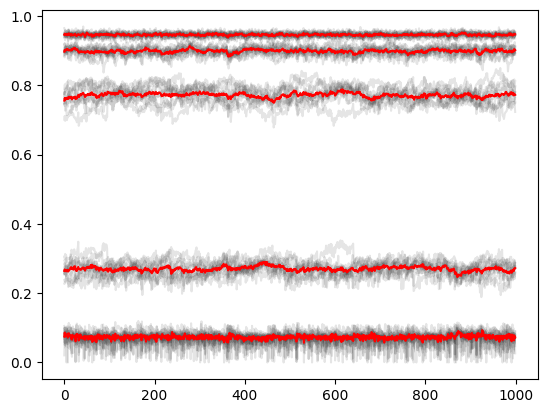

In [15]:
for i in range(len(history)):
    plt.plot(history[i], color='black', alpha=0.1)

plt.plot(history.mean(axis=0), color='red');

In [18]:
rounded_particles = torch.round(particles.detach().clone())

In [19]:
isvalid(rounded_particles)

tensor([True, True, True, True, True, True, True, True, True, True])

In [20]:
potential(rounded_particles)

tensor([-35., -35., -35., -35., -35., -35., -35., -35., -35., -35.])